_Julia Callebat_

***

# Introduction

This work is mainly based on the work of Victor V. Albert, Kyungjoo Noh and Kasper Duivenvoorden in _Performance and structure of bosonic codes_ ([arXiv:1708.05010 quant-ph](https://arxiv.org/pdf/1708.05010.pdf)). In this paper, they focus on five different code classes: the `cat`-codes, the `binomial` codes, the `num`erically optimized codes, and the `gkps` and `gkp` codes. They are all continuous-variable (CV) encoding schemes developped more or less recently, the `cat` and `gkp(s)` codes dating back to 1999 and the `bin` and `num` codes recently designed. 

Their purpose is to compare those codes using one same error model. Here, they focus on the bosonic pure-loss channel, the best model for the optical cavities. Photon loss is indeed the most common incoherent error process, and the most important in terms of effects on the transmission. 

It should be noted however that this work is highly theoritical; it consists of numerical analysis of the theoritical performances of those codes, assuming that the encoding, recovery and decoding operations are done perfectly. Thus, their results are loose guidelines and not practical suggestions. 


I use in particular their study of the expressions of the logical states of the codes aforementioned, and of the pure-loss channel in itself. My goal is to provide a visual representation of the codes before and after the pure-loss channel, and to see whether the results of the paper on the quality of the codes in absolute and in respect to one another can be seen using the Wigner function as a visual representation. I will also plot the trace distance between two codewords and between those codewords and the vacuum, in order to check whether the pure-loss channel as I represent it indeed collapses the states to the vacuum for large loss rates. Next to this, I will plot the inner product of the two codewords considered to see how the overlap evolves according to the loss rate.


## Remarks

This work is done using Python, and more precisely the [QuTiP library](http://qutip.org/docs/latest/index.html "Quantum Toolbox in Python"). While some numerical decisions are motivated by the article on which this work is based, whether because of physical or practical reasons, some are mostly made because of the limitations of Python. In any case, justification will be provided for all those decisions. 



In [3]:
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt
import math

***

# The bosonic pure-loss channel

This is one of the prevailing CV noise models, alongside the classical noise (Gaussian noise or displacement). It is a contraction of phase space to the vacuum. It is also knows more simply as the lossy channel, and we use here $\gamma$, the dimensionless loss rate parameter to characterize the channel: it is function of the damping parameter, which is expressed differently for microwave or optical cavities (function then of the excitation loss rate and time interval) and for optical fibers (function tthe of the fiber length and attenuation length).

The pure-loss channel can be described by its Kraus operators, given in (1.4). However, for practicality (Python does not support infinite sums of non-integer), we have to approximate the sum. It is said in the paper that "to leading order in $\gamma$, expansions of the first two Kraus operators suffice"; thus I calculated at first the states after the channel using the following code:

In [2]:
# def E_0(N, gamma):
#    l = Qobj()
#    l = qeye(N) - 1/2*gamma*num(N)
#    return l
    
# def E_1(N, gamma):
#    l = Qobj()
#    l = np.sqrt(gamma)/np.sqrt(1-gamma)*(1-gamma/2)*destroy(N)
#    return l

# def E_2(N, gamma):
#    l = Qobj()
#    l = (gamma/(1-gamma))*(destroy(N))**2/np.sqrt(2)*(1-gamma*num(N)/2)
#    return l


* $E_0$ is function of the Identity matrix and the number operator (the product of the raising and lowering operators), while $E_1$ is function only of the lowering operator. 
* The $N$ parameter represents the number of levels in Hilbert space. Since the mean occupation number studied in the original paper does not exceed 10, we will take $N = 20$ in all following calculations in order to keep those objects easily computable by Python.
* $E_2$ was added after the first computations of the distance between the codewords gave unexpected result, to check that there was no major imprecision due to only using the first two Kraus operators. It showed to have little to no impact on all the plots, which can be because adding only one Kraus operator is not enough to better the simulation.

***

As the Kraus operators act on the density matrix representations of the states, we define the `density` function that, given a pure state, returns its density matrix -- the product of the state ket and its bra. We use the `dag()` function of QuTiP that gives the state dagger.

In [4]:
def density(state):
    l = Qobj()
    l = state*state.dag()
    return l

***

Then, we can fully describe the effect of the channel on the density matrix of a logical state using the following function:

In [4]:
# def channel(dens, N, gamma):
#    l = Qobj()
#    l = E_0(N,gamma)*dens*E_0(N,gamma).dag() + E_1(N,gamma)*dens*E_1(N,gamma).dag() + E_2(N,gamma)*dens*E_2(N,gamma).dag()
#    return l

***

Yet, as mentionned before, this representation lead to unexpected plot results for the distance between codewords and the vacuum state. Thus we set for a more precise definition of the channel using the sum of the first 150 Kraus operators -- Python does not manage to compute easily the factorial of bigger numbers. This has lead to significant changes of the Wigner function plot for $\gamma$ greater than 0.2, but has not altered the global shape of the trace distance functions.

The Kraus operators are defined in the original paper (1.4) : 

$$ E_l = \left(\dfrac{\gamma}{1 - \gamma}\right)^{l/2} \dfrac{â^l}{\sqrt{l!}}(1 - \gamma)^{\hat{n}/2} $$

Since QuTiP cannot compute powers of operators, we use the expansion to leading order of $\gamma$.

In [5]:
def E_l(N, gamma, l):
    k = Qobj()
    k = (gamma/(1-gamma))**(l/2)*(1-gamma/2)/math.sqrt(np.math.factorial(l))*destroy(N)**l
    return k

def channel(dens, N, gamma):
    l = Qobj()
    l = sum((E_l(N, gamma, k)*dens*E_l(N, gamma, k).dag()) for k in range(0,150))
    return l

## Alternative definition

The lossy channel could also be expressed using QuTiP's function `mesolve` to solve the equation describing the evolution in time of the density matrix, using the Lindbald operators. Yet here we don't study the evolution in time but the difference between states after the channel for various loss rates $\gamma$. Since I couldn't find how to link the two descriptions, we will stay with the approximation defined before.

***

# The cat code
## Definition

The `cat` codes are defined by their parameters $\alpha$, and $S$. Those parameters being given, the cat code logical states are coherent states (function of $\alpha$) projected onto subspaces of occupation number modulo $2(S + 1)$. Thus, the $S$ parameter gives the spacing between Fock states supporting the logical states, or, when using the coherent states instead of the Fock states, the $S$ parameters gives the number of coherent states used. In the large $\alpha$ limit, it gives exactly the number of coherent states distributed equidistantly on a circle of radius $\alpha$ in phase space, which is to say it gives the spacing ($1/(2(S+1))$) between the coherent states on the circle of radius $\alpha$ in phase space. 
  
The $S$ parameter being the spacing between the Fock states supporting the two different logical states, it gives also the number of loss events that can be detected -- but that cannot always be correctable.

***
The global expression of those logical states is given in equation (5.1), but for the purposes of our work we will use the simple example of the `cat(alpha = 2, S = 1)` code and thus the expression given by equation (5.8). The $S = 1$ parameter have been chosen by the authors of the original paper for simplicity reasons, and I have set at first $\alpha$ to be equal to 2 in order to be able to compare my representation to the one given in Figure 1.

Since $S = 1$, exactly one loss event is always detectable but not always correctable. Furthermore, as show in Figs. 4(a-c), there exists a "sweet spot" for `cat` codes, that is to say an $\alpha^*$ that balances the backaction with the loss errors. At this precise spot, the occupation numbers of the two logical states coincide. Yet it is said latter in this paper that $\alpha^* = 1.538$ for $S = 1$, meaning that they didn't plot the optimum code. We will plot also the maximally mixed state for this value of $\alpha$ to see if the difference is visible or not.
***

The function that gives the two logical states is thus defined as follow, with $\mu$ in {0,1} being the logical state considered:

$$ \mid\mu^{S = 1}_{cat}\rangle = \dfrac{\mid\alpha\rangle + \mid-\alpha\rangle + (-1)^\mu (\mid i\alpha\rangle + \mid-i\alpha\rangle)}{4 \sqrt{3[\cosh \alpha ^2 + (-1)^\mu \cos \alpha ^2]}} $$

In [6]:
def cat_L(N, alpha, mu):
    l = Qobj()
    l = (
        coherent(N,alpha) + coherent(N, -alpha) 
        + ((-1)**mu)*(coherent(N,1J*alpha)+coherent(N,-1J*alpha))
    )/(4*np.sqrt(2*(np.cosh(alpha**2) + ((-1)**mu)*np.cos(alpha**2))))
    return l.unit()

## Representation of the logical states

In order to have the clearest and most complete representation possible, we plot the two logical states $\mid0\rangle_{cat}$ and $\mid1\rangle_{cat}$.

As mentionned in the introduction, we use the Wigner function plots for the visual representation, since the Wigner function can be seen as the realisation of the density matrix in phase space.

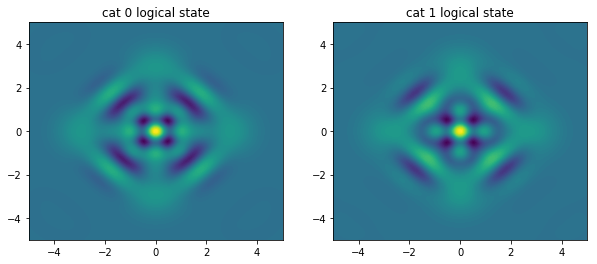

In [7]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
W_cat_0 = wigner(cat_L(20, 2, 0), xvec, xvec)
W_cat_1 = wigner(cat_L(20, 2, 1), xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_cat_0, 100)
lbl0 = axes[0].set_title("cat 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_cat_1, 100)
lbl1 = axes[1].set_title("cat 1 logical state")
plt.show()

We can then also plot the Wigner function of the maximally mixed state $\frac{1}{2} \left( \mid0\rangle_{cat}\langle0\mid_{cat} + \mid1\rangle_{cat}\langle1\mid_{cat} \right)$ to check if what we obtain is coherent with what is shown in Figure 1 in the original paper.

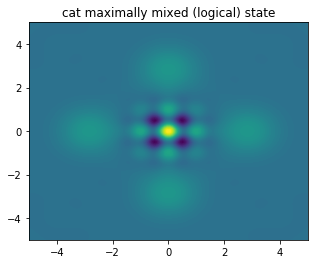

In [8]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cat_mixed = (1/2*(cat_L(20, 2, 0)*cat_L(20, 2, 0).dag() + cat_L(20, 2, 1)*cat_L(20, 2, 1).dag()))
W_cat_mixed = wigner(cat_mixed, xvec, xvec)
cont = axes.contourf(xvec, xvec, W_cat_mixed, 100)
lbl = axes.set_title("cat maximally mixed (logical) state")
plt.show()

We indeed obtain a plot comparable to the one of the original paper. We can thus be confident about our representation of the `cat` code.

We then plot this same state but for a different value of $\alpha$. We set this time $\alpha = 1.538$ in order to have the $S = 1$ `cat` code that can both detect and correct a single loss event in the small $\gamma$ limit, and see if it differs greatly from the previous one.

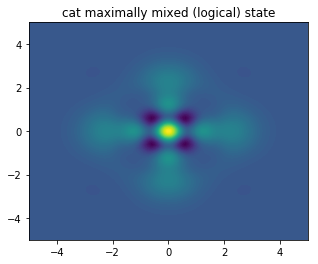

In [19]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 1, figsize=(5,4))
cat_mixed = (1/2*(cat_L(20, 1.538, 0)*cat_L(20, 1.538, 0).dag() + cat_L(20, 1.538, 1)*cat_L(20, 1.538, 1).dag()))
W_cat_mixed = wigner(cat_mixed, xvec, xvec)
cont = axes.contourf(xvec, xvec, W_cat_mixed, 100)
lbl = axes.set_title("cat maximally mixed (logical) state")
plt.show()

This second plot ressemble the previous one, but seems more blurry, which could be because the two logical states $\mid 0\rangle_{cat}$ and $\mid1\rangle_{cat}$ are further apart. We will thus use this value int the following calculations, in order to study the best `cat` code possible.

***

## Pure-loss channel

We apply the pure-loss channel with $\gamma$ varying in [0.01, 0.05, 0.10, 0.20, 0.31]. This ensemble have been chosen because it is the loss rates used to study the channel infidelity for the various codes in Table I. Indeed those loss rates give a good sample of pure-loss channels with a reasonable amount of loss, while accounting for the imprecision of the channel model used for larger $\gamma$, as the Kraus operators have been expanded to first order in $\gamma$.

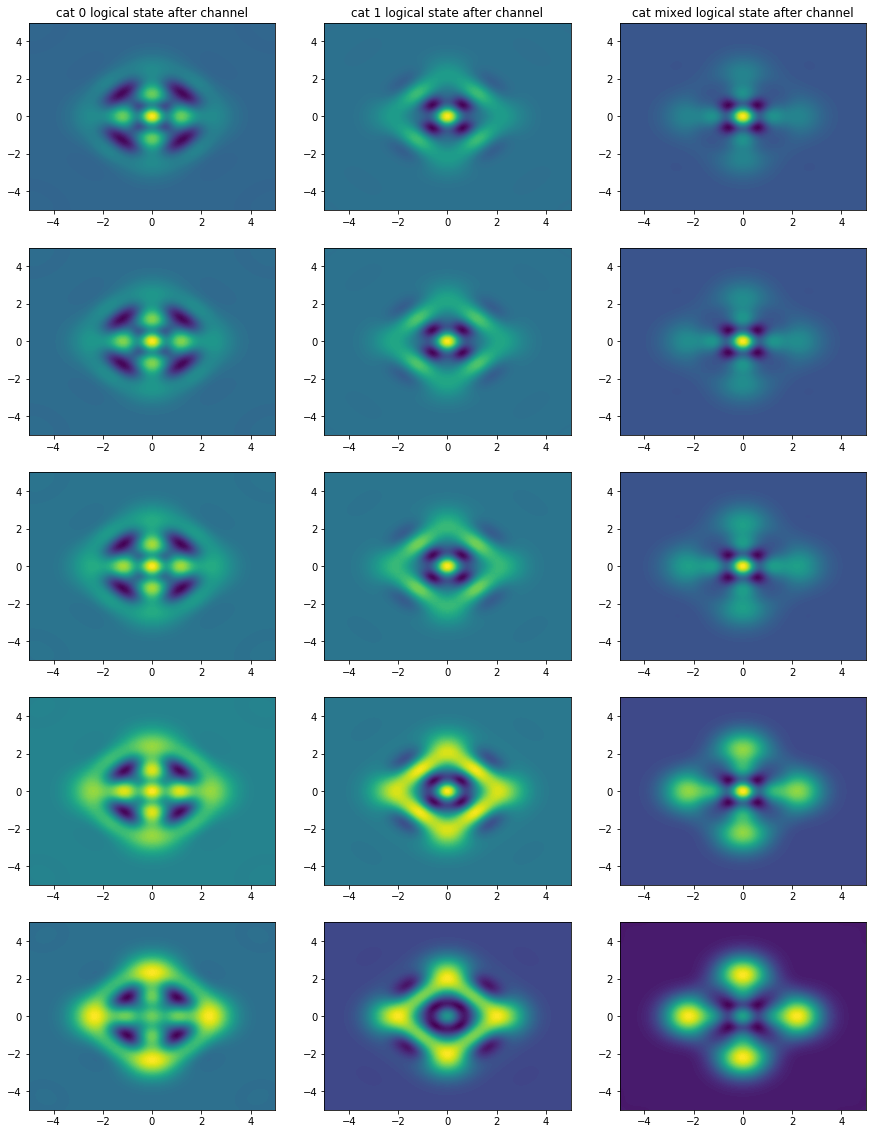

In [20]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("cat 0 logical state after channel")
lbl1 = axes[n][1].set_title("cat 1 logical state after channel")
lbl2 = axes[n][2].set_title("cat mixed logical state after channel")
for gamma in (0.01,0.05,0.1,0.2,0.31):
    W_cat_0_C = wigner(channel(density(cat_L(20, 1.538, 0)), 20, gamma), xvec, xvec)
    W_cat_1_C = wigner(channel(density(cat_L(20, 1.538, 1)), 20, gamma), xvec, xvec)
    W_cat_m_C = wigner(channel(density(cat_mixed), 20, gamma), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_cat_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_cat_1_C, 100)
    cont2 = axes[n][2].contourf(xvec, xvec, W_cat_m_C, 100)
    n = n+1
plt.show()

As assumed earlier, we indeed see a greater difference between $\mid 0\rangle_{cat}$ and $\mid1\rangle_{cat}$ at $\alpha^*$ than at $\alpha = 2$, which we can interpret as a smaller overlap between those two states. However, the propriety of $\alpha^*$ that the two codewords have the same occupation number is not visible on this representation.

Up to $\gamma = 0.1$ we see a concentration on certain points, and the patterns become less clear. However, for $\gamma = 0.2$ and $\gamma = 0.31$ we see a clear darkening of the plot, with the final one for the mixed state being close to only four points in void space. This is coherent with the contraction of the phase space.

Despite this, we still see a clear difference between the $\mid0\rangle_{cat}$ and $\mid1\rangle_{cat}$ logical states even at rather high loss rates, which corroborates the good ability of this `cat` code to protect exactly against such errors.

## Overlap between codewords

Let us also plot the evolution of the overlap between the $\mid0\rangle_{cat}$ and $\mid1\rangle_{cat}$ codewords, as the $\gamma$ parameter increases. We use the trace distance provided by the `tracedist` QuTiP function, and the Hilbert-Schmidt inner product given by `hilbert_dist`.

We do not restrain our plot to the five $\gamma$ values used before, and plot the distances and overlap for a great number of points between 0 and 0.3.

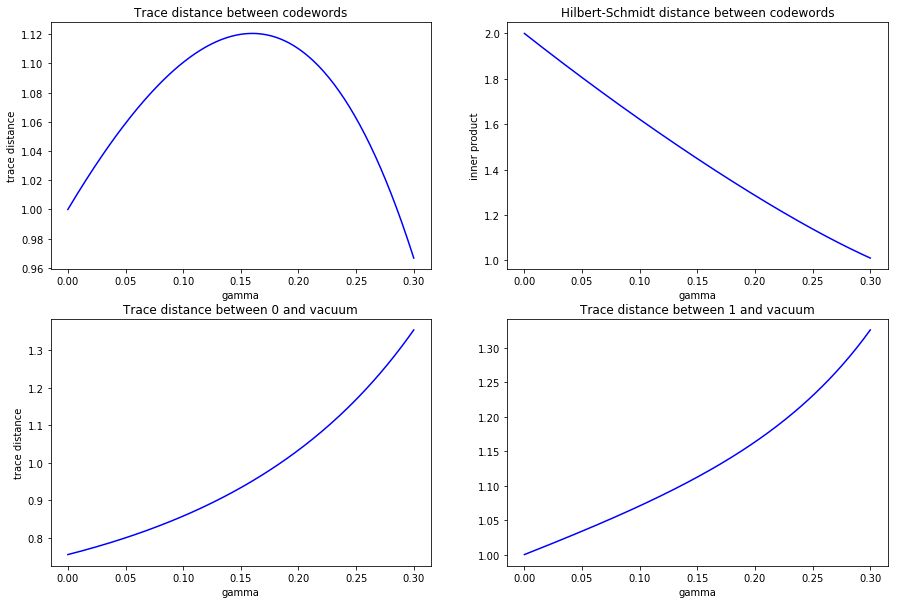

In [30]:
d_0 = density(cat_L(20, 1.538, 0))
d_1 = density(cat_L(20, 1.538, 1))
vac = fock_dm(20, 0)

xvec = np.linspace(0,0.3,200) # gamma
yvec1 = [(tracedist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # trace distance between codewords
yvec2 = [(tracedist(channel(d_0, 20, gamma), vac)) for gamma in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(channel(d_1, 20, gamma), vac)) for gamma in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gamma')
ax[1][0].set_xlabel('gamma')
ax[0][1].set_xlabel('gamma')
ax[1][1].set_xlabel('gamma')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

We see that, contrary to what we expected, the states do not get closer to the vacuum as $\gamma$ increases. What is moren the overlap between $\mid 0\rangle_{cat}$ and $\mid1\rangle_{cat}$ decreases, which does not seem logical either. 

Let us plot those functions for greater values of $\gamma$ (~ 0.6), to see if those trends are confirmed as we lose in precision of the channel description used.

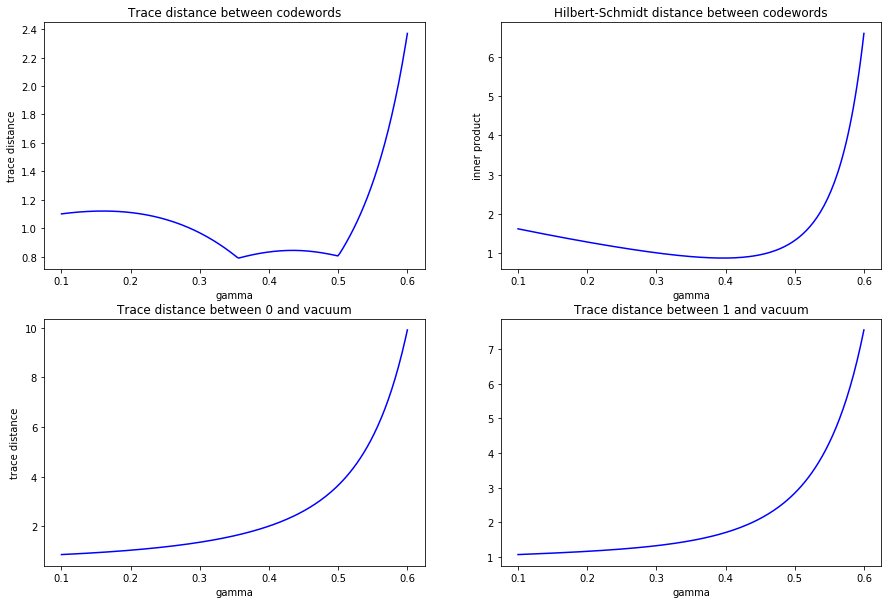

In [23]:
d_0 = density(cat_L(20, 1.538, 0))
d_1 = density(cat_L(20, 1.538, 1))
vac = fock_dm(20, 0)

xvec = np.linspace(0.1,0.6,200) # gamma
yvec1 = [(tracedist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # trace distance between codewords
yvec2 = [(tracedist(channel(d_0, 20, gamma), vac)) for gamma in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(channel(d_1, 20, gamma), vac)) for gamma in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gamma')
ax[1][0].set_xlabel('gamma')
ax[0][1].set_xlabel('gamma')
ax[1][1].set_xlabel('gamma')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

We see that indeed those trends are confirmed, with the exception of the overlap that greatly increases, starting around 0.4; also, the trace distance between the codewords starts to increase around 0.5.

Let us plot the fidelity of the channel for the various $\gamma$, as defined in the paper as the overlap between the initial state (represented by the density matrices `d_0`) and the final state (obtained by the function `channel` previously defined). We use the QuTiP function `fidelity`, and we plot for different subsets of $\gamma$ to get a clear picture.

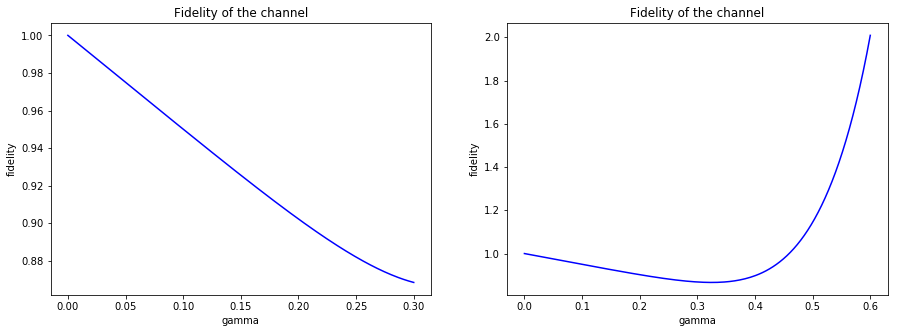

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
xvec0 = np.linspace(0,0.3,200) # small gamma
xvec1 = np.linspace(0,0.6,200) # greater range for gamma
yvec0 = [fidelity(d_0, channel(d_0, 20, gamma)) for gamma in xvec0]
yvec1 = [fidelity(d_0, channel(d_0, 20, gamma)) for gamma in xvec1]

p0 = ax[0].plot(xvec0, yvec0, 'b')
p1 = ax[1].plot(xvec1, yvec1, 'b')
ax[0].set_xlabel('gamma')
ax[1].set_xlabel('gamma')
ax[0].set_ylabel('fidelity')
ax[1].set_ylabel('fidelity')
ax[0].set_title('Fidelity of the channel')
ax[1].set_title('Fidelity of the channel')

plt.show()

We have here yet another unexpected result. Contrary to what could have been thought while looking at the previous plots, the channel description used is rather if not good, at least coherent with the one of the original paper for $\gamma < 0.3$. Indeed, we can compare the first plot to the one on Figure 2.(b) (indeed, $n \leq 5$ corresponds to the code selected, which has $n \approx 2.324$), and observe similarities. Indeed, up to $\gamma = 0.3$, we have the same decrease from 1 to about 0.9. The main difference is that here we have a very linear function, which is not the case in the paper.


We can thus conclude that for $\gamma \leq 0.3$ the limitations induced by the finite sum of the Kraus operators are not that bad; we don't have to discard the analysis for the codes up to this bound as completely false. We will thus later on restrict ourselves to $\gamma \leq 0.3$.

***

Coming back to the trace distance and the overlap for those values, we can note some remarks:

* Although the trace distance between the $\mid0\rangle_{cat}$ and $\mid1\rangle_{cat}$ states and the vacuum state have the same shape, $\mid0\rangle_{cat}$ starts "further" from the vacuum;

* The trace distance between the two logical states follows a "bell" curve, as if there was an optimum for this code at $\gamma \approx 0.15$. Nevertheless, this is not confirmed by any of the other plots. 

****

# The binomial code
## Definition

The `bin` codes are defined by two parameters, $N$ and $S$. This $N$ is not to be mistaken with the $N$ previously defined as the number of levels in the Hilbert space; here, it defines to which order in $\gamma$ the code can correct exactly dephasing errors. It can be seen as similar to the $\alpha$ parameter in the `cat` codes. The second parameter, $S$ is the same spacing parameter as for the `cat` code, defining the spacing of the Fock states supporting the logical states. This similarity between the `bin` and `cat` is best seen in the fact that, for a fixed $S$, they are equivalent for $\alpha$ and $N$ close to infinity.

Thus, it comes as no surprise that `bin` codes can detect and sometimes correct errors due to loss events in the same way that `cat` codes do.

The main difference between `bin` and `code` codes come at larger $S$: since there exists those so-called "sweet spots" for the `cat` codes, there is an intermediate $n$ regime, between those sweet spots, in which the `cat` codes underperforms while the `bin` continue to improve. However, since for the visual representations we stay at low levels of $S$, the two codes should not seem to perform differently.

***

Here we have chosen the `bin(N = 1, S = 2)` for the sole reason that it is the one represented in the original paper in Figure 1, and we can thus compare our representation of the maximally mixed state of this code with the original one. We use the equation (6.1) to express the logical states:

$$ \mid \mu_{bin} \rangle = \dfrac{1}{\sqrt{2^{N+1}}} \sum^{N+1}_{m=0} (-1)^{\mu m} \sqrt{\left( \begin{array}{c} N + 1 \\ m
  \end{array} \right)} \mid (S+1)m \rangle $$
  
For the specific case of $N=1$ and $S=2$ we have:

In [32]:
def bin_L(N, mu):
    l = Qobj()
    l = fock(N,0) + ((-1)**mu)*np.sqrt(2)*fock(N,3) + fock(N,6)
    l = 1/2*l
    return l.unit()

## Representation of the logical states

We use the same code -- same plotting function, same size, same dimension -- as for the `cat` code. We represent the $\mid0\rangle_{bin}$ and $\mid1\rangle_{bin}$ and maximally mixed state side by side.

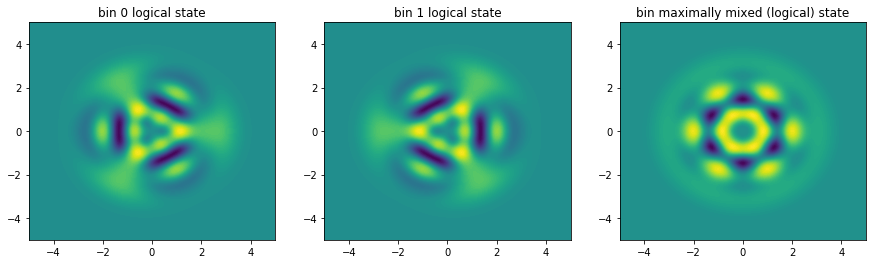

In [33]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 3, figsize=(15,4))
W_bin_0 = wigner(bin_L(20, 0), xvec, xvec)
W_bin_1 = wigner(bin_L(20, 1), xvec, xvec)
bin_mixed = (1/2*(bin_L(20, 0)*bin_L(20, 0).dag() + bin_L(20, 1)*bin_L(20, 1).dag()))
W_bin_mixed = wigner(bin_mixed, xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_bin_0, 100)
lbl0 = axes[0].set_title("bin 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_bin_1, 100)
lbl1 = axes[1].set_title("bin 1 logical state")
cont2 = axes[2].contourf(xvec, xvec, W_bin_mixed, 100)
lbl2 = axes[2].set_title("bin maximally mixed (logical) state")
plt.show()

The plot for the maximally mixed state is very similar to the one on Figure 1 in the original paper. We thus again continue confidently our analysis.

***

## Pure-loss channel

We then apply the pure-loss channel defined earlier on those three quantum states, using the same ensemble for the $\gamma$ variable:

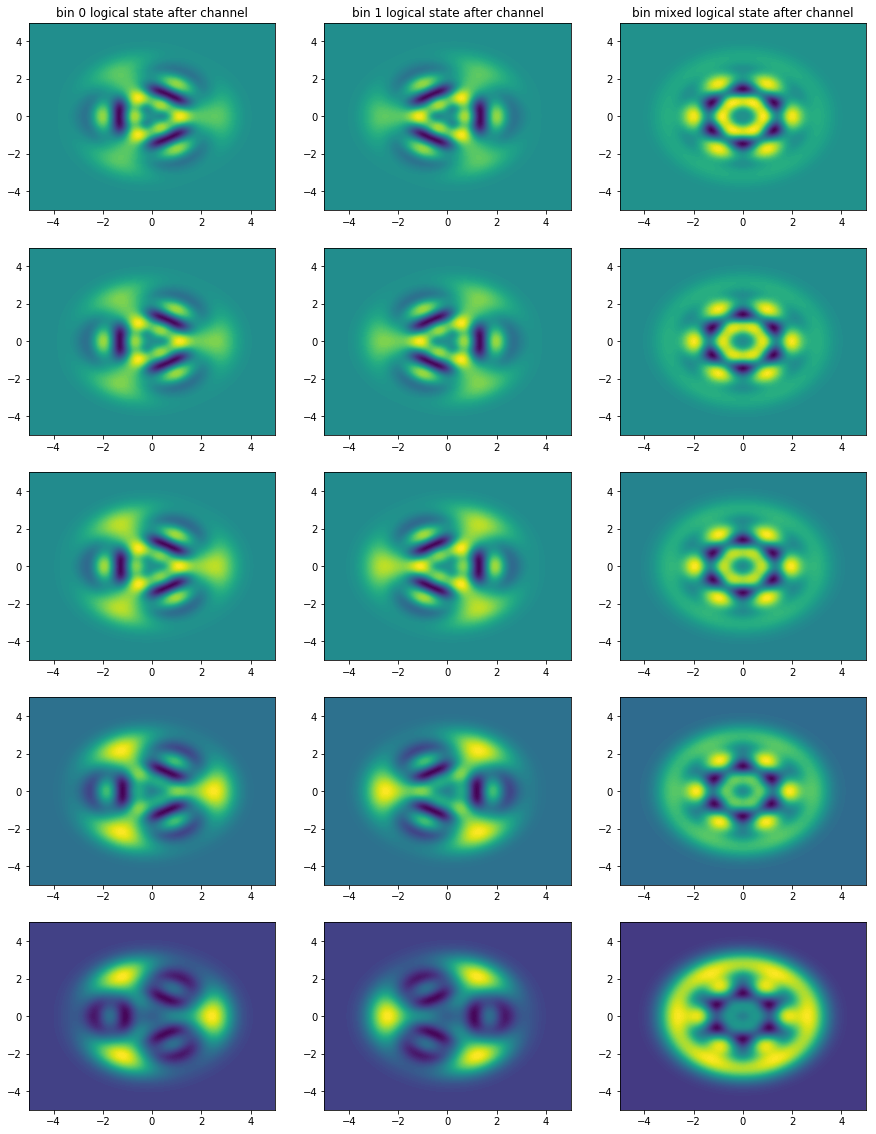

In [13]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("bin 0 logical state after channel")
lbl1 = axes[n][1].set_title("bin 1 logical state after channel")
lbl2 = axes[n][2].set_title("bin mixed logical state after channel")
for gamma in (0.01,0.05,0.1,0.2,0.31):
    W_bin_0_C = wigner(chan(density(bin_L(20, 0)), 20, gamma), xvec, xvec)
    W_bin_1_C = wigner(chan(density(bin_L(20, 1)), 20, gamma), xvec, xvec)
    W_bin_m_C = wigner(chan(density(bin_mixed), 20, gamma), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_bin_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_bin_1_C, 100)
    cont1 = axes[n][2].contourf(xvec, xvec, W_bin_m_C, 100)
    n = n+1
plt.show()

Here again we lose clarity as the loss rate increases, with again this darkening, only this time starting later, around $\gamma = 0.3$. Still, the distinction between the density matrices of the two basis states is clearly visible. This goes along the results of the original paper. 

However, using only the visual representation, there seems to be no way of comparing the efficiency of the different codes. Though the `bin` and `cat` codes, such chosen, are shown by a numerical analysis to perform similarly, this cannot be seen by comparing only the density matrices. In order to make such a comparison, we will use the channel fidelity as defined earlier, which, as a function of the original and final state vectors, cannot be seen on this Wigner representation. 

The only thing that can be seen when comparing those two codes is that, considering the maximally mixed states, the blurring of the Wigner function seems to increase at the about the same rate.

## Overlap between codewords

As argued before, and since the channel representation is the same for all the codes considered, we only plot the trace distances and the overlap for the values of $\gamma$ that have been deemed "good enough".

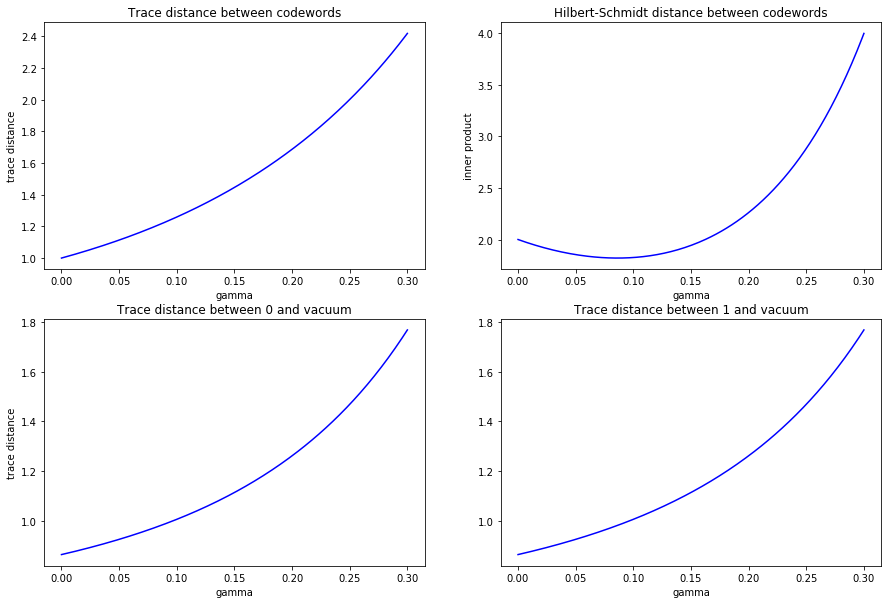

In [35]:
d_0 = density(bin_L(20, 0))
d_1 = density(bin_L(20, 1))
vac = fock_dm(20)

xvec = np.linspace(0,0.3,200) # gamma < 0.3
yvec1 = [(tracedist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # trace distance between codewords
yvec2 = [(tracedist(channel(d_0, 20, gamma), vac)) for gamma in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(channel(d_1, 20, gamma), vac)) for gamma in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gamma')
ax[1][0].set_xlabel('gamma')
ax[0][1].set_xlabel('gamma')
ax[1][1].set_xlabel('gamma')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

We observe about the same general shape as for the `cat` codes for the distances with the vacuum. The main difference lies in the trace distance between codewords, which doesn't have the same shape nor the same values. While it varied little before -- from 1 to 1.12 --, and followed a bell shape,  it now goes from 1 to 2.4 rather linearly.

We also see a big difference in the overlap. While it starts at the same value -- 2.0 -- for both codes, it mostly increases for the `bin` code after a small decrease.

***

Let us now plot again the fidelity of the channel for this code, to see if we have still a global trend that goes according to the Figure 2.(b) of the original paper.

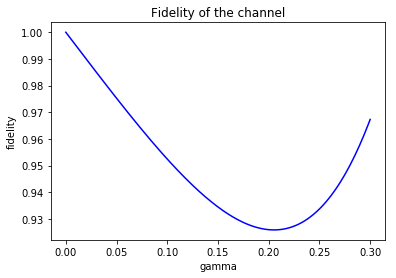

In [37]:
fig, ax = plt.subplots()
xvec = np.linspace(0,0.3,200)
yvec = [fidelity(d_1, channel(d_1, 20, gamma)) for gamma in xvec]

p = ax.plot(xvec, yvec, 'b')
ax.set_xlabel('gamma')
ax.set_ylabel('fidelity')
ax.set_title('Fidelity of the channel')

plt.show()

We observe that this time, the fidelity starts behaving weird before the 0.3 bound previously established. This shows that for $\gamma \in [0.15, 0.3]$, the expansion of the Kraus operators already starts to not be close enough to the exact expression. This difference between the two code class can be due simply to a lucky pick for the `cat` code that compensated the errors of approximation.

This could also mean that the increase in the overlap observed before for $\gamma > 0.1$ might be due to errors of approximation, and not intrisic proprierties of the `bin` codes.


***

# The numerical code
## Definition

The `num`erically optimized codes were designed, like the `bin` codes, to protect exactly against errors consisting of powers of raising and lowering operators, up to some maximum order here defined by the $n$ parameter. 

I could not find a formal definition of this class of codes, nor in the original paper nor in the one cited as source for some of those codes. Because of this, we use the expression of the logical states of a `num` given in appendix B for $n = 1.562$ -- the only one to be found. We observe that, similarly to the previous `bin` codes, the basis logical states are supported by Fock states. Nevertheless, the spacing here is not constant, the $\mid0\rangle_{num}$ state being supported by the $\mid0\rangle$ and $\mid3\rangle$ Fock states, and the $\mid1\rangle_{num}$ by the $\mid1\rangle$ and $\mid4\rangle$ Fock states.

In [47]:
def num_L(N, mu):
    l = Qobj()
    if (mu == 0):
        l = 1/np.sqrt(6)*(np.sqrt(7-np.sqrt(17))*fock(N,0)+np.sqrt(np.sqrt(17)-1)*fock(N,3))
    if (mu == 1):
        l = 1/np.sqrt(6)*(np.sqrt(9-np.sqrt(17))*fock(N,1)+np.sqrt(np.sqrt(17)-3)*fock(N,4))
    return l.unit()

## Representation of the logical states

We keep the same canvas as before to plot the three chosen logical states:

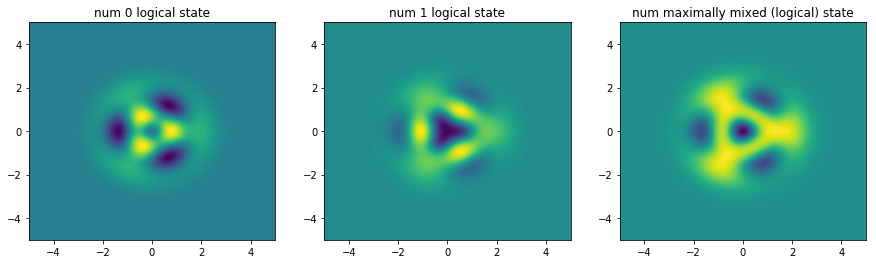

In [48]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 3, figsize=(15,4))
W_num_0 = wigner(num_L(20, 0), xvec, xvec)
W_num_1 = wigner(num_L(20, 1), xvec, xvec)
num_mixed = (1/2*(num_L(20, 0)*num_L(20, 0).dag() + num_L(20, 1)*num_L(20, 1).dag()))
W_num_mixed = wigner(num_mixed, xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_num_0, 100)
lbl0 = axes[0].set_title("num 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_num_1, 100)
lbl1 = axes[1].set_title("num 1 logical state")
cont2 = axes[2].contourf(xvec, xvec, W_num_mixed, 100)
lbl2 = axes[2].set_title("num maximally mixed (logical) state")
plt.show()

Unfortunatly, we cannot compare this mixed state to the one ploted in Figure 1 in the original paper, since we only have the formula for the logical states for `num(n = 1.562)` and they plotted `num(n = 2.696)`. Still, we observe similar symetries, and the same round pattern.

***

## Pure-loss channel

Here again we plot the state after applying the channel's first 150 Kraus operators:

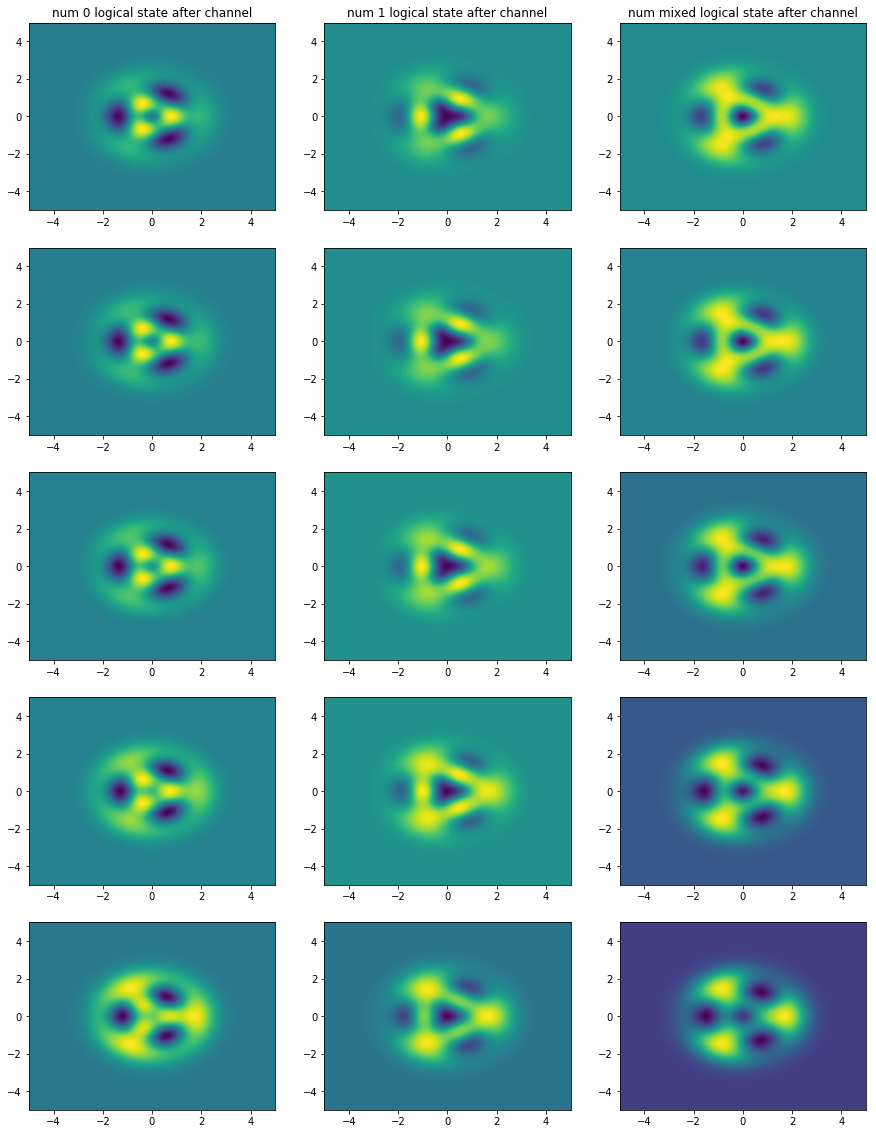

In [17]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("num 0 logical state after channel")
lbl1 = axes[n][1].set_title("num 1 logical state after channel")
lbl2 = axes[n][2].set_title("num mixed logical state after channel")
for gamma in (0.01,0.05,0.1,0.2,0.31):
    W_num_0_C = wigner(chan(density(num_L(20, 0)), 20, gamma), xvec, xvec)
    W_num_1_C = wigner(chan(density(num_L(20, 1)), 20, gamma), xvec, xvec)
    W_num_m_C = wigner(chan(density(num_mixed), 20, gamma), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_num_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_num_1_C, 100)
    cont1 = axes[n][2].contourf(xvec, xvec, W_num_m_C, 100)
    n = n+1
plt.show()

We once again observe a blurring of the Wigner plot, a concentration on a few spots for the maximally mixed state and a darkening around it, happening for $\gamma > 0.2$.

## Overlap of the codewords

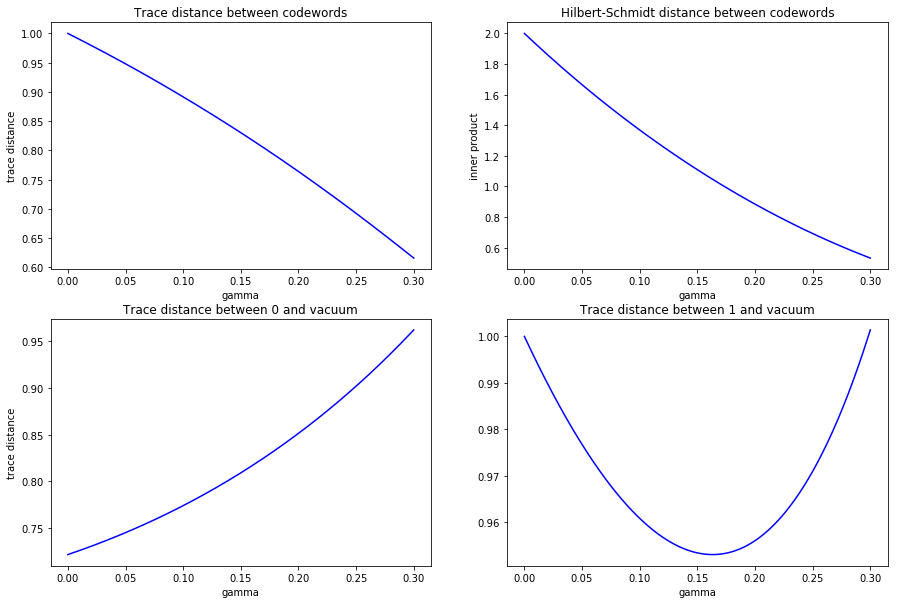

In [40]:
d_0 = density(num_L(20, 0))
d_1 = density(num_L(20, 1))
vac = fock_dm(20)

xvec = np.linspace(0,0.3,200) # gamma
yvec1 = [(tracedist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # trace distance between codewords
yvec2 = [(tracedist(channel(d_0, 20, gamma), vac)) for gamma in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(channel(d_1, 20, gamma), vac)) for gamma in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gamma')
ax[1][0].set_xlabel('gamma')
ax[0][1].set_xlabel('gamma')
ax[1][1].set_xlabel('gamma')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

The `num` code has better performance in the original paper than the `cat` and `bin` codes, yet this does not appear obvious from those plots. Quite on the contrary, the trace distance between $\mid0\rangle_{num}$ and $\mid1\rangle_{num}$ decreases, which could mean that they get closer one to another and thus more difficult to tell appart, but so does the overlap between those two states, that decreases even more than the other two code classes -- from 2.0 to 0.6 against from 2 to 1 for the `cat` code and a yet smaller decrease (for $\gamma < 0.1$) for the `bin` code. 

What is even weirder is the evolution of the trace distance with the vacuum. Although it increases for $\mid0\rangle_{num}$ just as before, it starts by decreasing for $\mid1\rangle_{num}$, with a minimum around 0.15. This evolution, just like the other ones, does not make much sense.

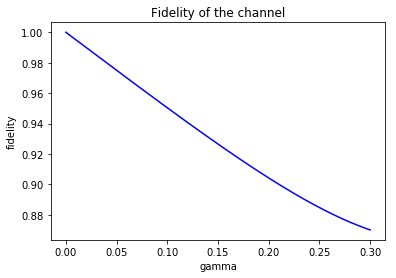

In [41]:
fig, ax = plt.subplots()
xvec = np.linspace(0,0.3,200)
yvec = [fidelity(d_1, channel(d_1, 20, gamma)) for gamma in xvec]

p = ax.plot(xvec, yvec, 'b')
ax.set_xlabel('gamma')
ax.set_ylabel('fidelity')
ax.set_title('Fidelity of the channel')

plt.show()

This time, just like for the `cat` code, the fidelity keeps decreasing until past $\gamma = 0.3$, which would tend to point towards the hypothesis that we were unlucky and chose a `bin` code that exagerated the errors due to the approximation in the channel computation.

Yet it should be noted also that its decrease is very much like the one for the `cat` code, even in its value: it goes from 1 to just below 0.88, while it is made very clear in the Figure 2.(b) of the original paper that, for those values of $\gamma$, the `num` codes perform much better than the two previously studied. This goes to show that our approximation is not good enough to show the differences in performance of the various codes studied here.

***

# The GKPs codes
## Definition

The `gkps` codes are the first `gkp` code type designed, with the s standing for "square", because those first codes were based on square lattices. It is only latter on that more general `gkp` codes were introduced with shifted lattices. The `gkps` codes are presented seperatly to account for possible particularities according to the form of the lattice.

***

Those codes are constructed by adding a $\Delta^2$ dependent Gaussian envelope to the ideal square lattice `gkps` codespace, which, having infinite mean occupation number, is not normalizable. This one in turn is defined by its projection, which is the simultaneous +1 eigenspace of two commuting displacement operators. 

For practical reasons -- namely that the QuTiP library enable us to easily calculate those displacement operators -- we use the version without normalization given by equation (7.7b):

$$\mid \mu^\Delta_{gkps} \rangle \propto \sum_{\vec{n} \in \mathbb{Z}^2} e^{-\frac{\pi}{2}\Delta^2 [(2n_1+\mu)^2+n_2^2]} D_{\sqrt{\frac{\pi}{2}}(2n_1+\mu)} D_{i\sqrt{\frac{\pi}{2}}n_2} \mid0\rangle$$

However, since python does not support infinite summation of anything other than integers, we approximate the sum by its -100 to 100 terms. 

In [49]:
def gkps_L(N, mu, delta):
    l = Qobj()
    l = sum((sum(
        (np.exp(-(np.pi/2)*(delta**2)*((2*n+mu)**2 + k**2))
         *displace(N, (np.sqrt(np.pi/2)*(2*n+mu)))
         *displace(N, (1J*np.sqrt(np.pi/2)*k))
         *fock(N, 0)) 
        for k in range(-50,50))) for n in range(-100,100))
    return l.unit()

***Remark:*** Since the formula given by the paper is not normalized, we use the `unit` QuTiP function to have a unitary state.

## Representation of the logical states

We here take the parameter $\Delta$ to be 0.5, in order to be able to once again compare the Wigner function of the maximmaly mixed state we obtain to the one shown in Figure 1.

***Remark:*** Here, we calculate only once the logical states in order to minimize the calls to the `gkps_L` function which takes some time to compute due to the size of the double sum.

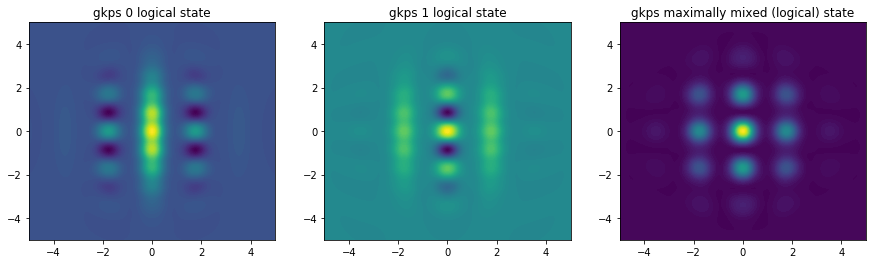

In [50]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(1, 3, figsize=(15,4))
gkps_0 = gkps_L(20, 0, 0.5)
gkps_1 = gkps_L(20, 1, 0.5)
W_gkps_0 = wigner(gkps_0, xvec, xvec)
W_gkps_1 = wigner(gkps_1, xvec, xvec)
gkps_mixed = (1/2*(gkps_0*gkps_0.dag() + gkps_1*gkps_1.dag()))
W_gkps_mixed = wigner(gkps_mixed, xvec, xvec)
cont0 = axes[0].contourf(xvec, xvec, W_gkps_0, 100)
lbl0 = axes[0].set_title("gkps 0 logical state")
cont1 = axes[1].contourf(xvec, xvec, W_gkps_1, 100)
lbl1 = axes[1].set_title("gkps 1 logical state")
cont2 = axes[2].contourf(xvec, xvec, W_gkps_mixed, 100)
lbl2 = axes[2].set_title("gkps maximally mixed (logical) state")
plt.show()

We indeed obtain the same plot, which confirms that we have well implemented the model described by this paper. 

They also mention that for non zero $\Delta$, the $\mid0\rangle_{gkps}$ and $\mid1\rangle_{gkps}$ logical states are non-orthogonal, which spans error inherent to the code structure. However, this propriety does not seem obvious when seeing those two states side by side.

***

## Pure-loss channel

We once more use the same canvas to model the pure-loss channel action:

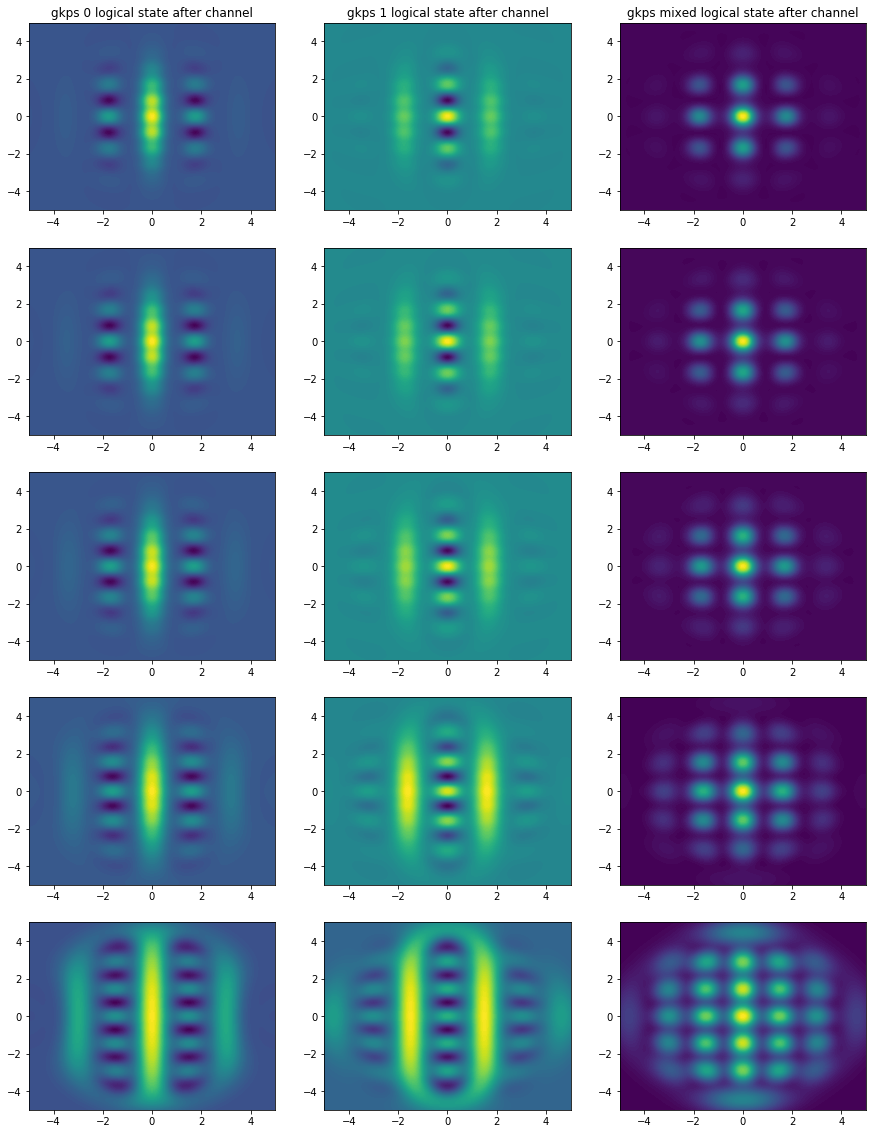

In [21]:
xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(5, 3, figsize=(15,20))
n = 0
lbl0 = axes[n][0].set_title("gkps 0 logical state after channel")
lbl1 = axes[n][1].set_title("gkps 1 logical state after channel")
lbl2 = axes[n][2].set_title("gkps mixed logical state after channel")
for gamma in (0.01,0.05,0.1,0.2,0.31):
    W_gkps_0_C = wigner(chan(density(gkps_0), 20, gamma), xvec, xvec)
    W_gkps_1_C = wigner(chan(density(gkps_1), 20, gamma), xvec, xvec)
    W_gkps_m_C = wigner(chan(density(gkps_mixed), 20, gamma), xvec, xvec)
    cont0 = axes[n][0].contourf(xvec, xvec, W_gkps_0_C, 100)
    cont1 = axes[n][1].contourf(xvec, xvec, W_gkps_1_C, 100)
    cont1 = axes[n][2].contourf(xvec, xvec, W_gkps_m_C, 100)
    n = n+1
plt.show()

Here we see a very different phenomenon than for the other codes. The code subspace does not suffer from a contraction, seen as a blurring of the plot for rather small $\gamma$ parameters, but from a more complexe distortion in which new patterns appear. This can be linked to the results on code performance of the original paper. Indeed, they found out that though `gkp` -- and more particularly `gkps` codes does not perform significantly better at low $\gamma$, they greatly outperform every other code type when `gamma > 0.1`, especially at higher mean occupation number. This limit is when the first distortions of the density matrix appear on the Wigner function plot.

Thus it seems that the `gkps` codes outperform the others at higher $\gamma$ because the distortion induced by the pure-loss channel increases the distinguishability of the two basis logical states, an effect that counterbalances the inherent errors of the `gkps` codes -- namely, that the two basis states are non-orthogonal -- and the errors induced by the channel.

## Overlap of the codewords

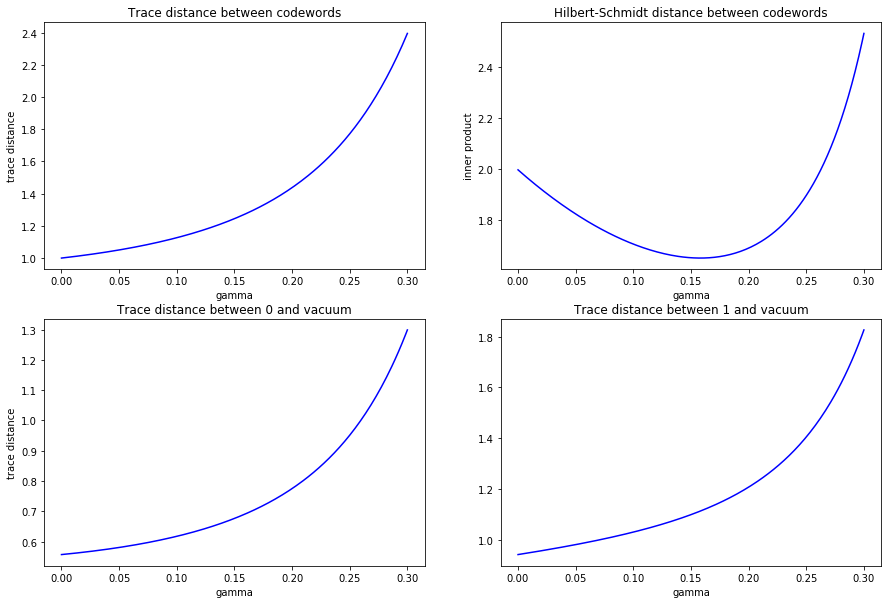

In [51]:
d_0 = density(gkps_0)
d_1 = density(gkps_1)
vac = fock_dm(20)

xvec = np.linspace(0,0.3,200) # gamma
yvec1 = [(tracedist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # trace distance between codewords
yvec2 = [(tracedist(channel(d_0, 20, gamma), vac)) for gamma in xvec] # trace dist between 0 and vacuum
yvec3 = [(tracedist(channel(d_1, 20, gamma), vac)) for gamma in xvec] # trace dist between 1 and vacuum
yvec4 = [(hilbert_dist(channel(d_0, 20, gamma), channel(d_1, 20, gamma))) for gamma in xvec] # Inner product between codewords

fig, ax = plt.subplots(2, 2, figsize=(15,10))
p0 = ax[0][0].plot(xvec, yvec1, 'b')
p1 = ax[0][1].plot(xvec, yvec4, 'b')
p1 = ax[1][0].plot(xvec, yvec2, 'b')
p1 = ax[1][1].plot(xvec, yvec3, 'b')
ax[0][0].set_xlabel('gamma')
ax[1][0].set_xlabel('gamma')
ax[0][1].set_xlabel('gamma')
ax[1][1].set_xlabel('gamma')
ax[0][0].set_ylabel('trace distance')
ax[0][1].set_ylabel('inner product')
ax[1][0].set_ylabel('trace distance')
ax[0][0].set_title('Trace distance between codewords')
ax[0][1].set_title('Hilbert-Schmidt distance between codewords')
ax[1][0].set_title('Trace distance between 0 and vacuum')
ax[1][1].set_title('Trace distance between 1 and vacuum')
plt.show()

We observe almost exactly the same plots and values that for the `bin` code, even though they are not similar neither in construction nor in performance.

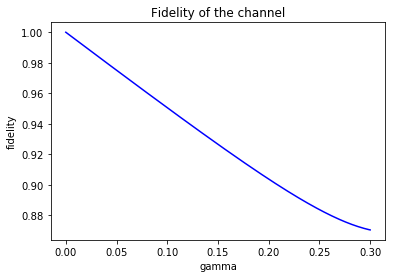

In [52]:
fig, ax = plt.subplots()
xvec = np.linspace(0,0.3,200)
yvec = [fidelity(d_1, channel(d_1, 20, gamma)) for gamma in xvec]

p = ax.plot(xvec, yvec, 'b')
ax.set_xlabel('gamma')
ax.set_ylabel('fidelity')
ax.set_title('Fidelity of the channel')

plt.show()

We have once again the same curve than for the `cat` and `num` codes, which tends to confirm that for $\gamma \in [0;0.3]$, our approximation in first order in $\gamma$ leads to coherent results, although with not enough precision to be able to compare one code to another. 

***

# Conclusion

We have succesfully plotted the logical states of different codes before and after going through a pure-loss channel. Although it is not possible using this visual representation to compare precisely the performance of these codes, it gives a rough estimate of the differences, mostly between the `gkp` codes and the others. 

Most importantly, it gives a nice visual representation of the effects of an increasing loss rate of the channel: the differences are clearly visible between the post-channel states for very low (0.01) and for higher (0.31) loss rates. Furthermore, those differences seem to increase continously.

This visual representation, although shown by the plotting of the fidelity of the channel to be very approximate, can still give a good sense of what happens to the density matrix of a state going through this channel.

It has yet to be understood whether the results concerning the trace distance with the vacuum, which are opposite to what was expected of a pure-loss channel that contracts phase space to the vacuum, are entirely false due to the errors in approximation of the Kraus operators, or if it shows a global trend that would hold true even with a better representation of the channel. 

It can also be noted that, though a visual interpretation of the evolution of the Wigner function of the different states studied seems to show indeed a contraction of phase space to a state closer to the vacuum -- for every code except `gkps`, and especially for the maximally mixed state which gets closer to a few dense points.

Although at first we wanted to plot the `gkps` and `gkp` code seperatly to see if any difference due to the shifted lattice could be visually represented, the formula for the `gkp` logical state, given in the original paper at (7.8), proved to be too complicated to implement. The main problem lied in representing in Python the state lattice for each code state, on which the summation is done to compute the code state. We would have expected very similar results for those two code classes, with the main difference being the Wigner representation which is very similar, but not arranged in a square lattice for the `gkp` code states.

***